In [ ]:
# If SOLVING_EXERCISES=True, runs the user's answers.
# If SOLVING_EXERCISES=False, only runs the provided solutions.
SOLVING_EXERCISES = True

In [ ]:
!pip install "pandas==2.0.3" "matplotlib<3.9.0" statsmodels "numpy==1.26.4" sktime temporian seaborn pmdarima -U -qq

<font color="red">WARNING:</font> Restart the notebook / colab kernel after the `pip install` commands above (e.g., Menu > Runtime / Restart settion). If you don't, you might get the `module 'numpy.linalg._umath_linalg' has no attribute '_ilp64'` error.

In [ ]:
from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import temporian as tp  # That's us!

sns.set()

# Part 2: Statistical Forecasting


Statistical forecasting are techniques that produce forecasts by extracting patterns and trends from historical data.

The underlying assumption when using Statistical Forecasting techniques is that future behaivour can be reasonably predicted from past behaviour. This is possible in many domains, but it might not be accurate in some cases.

Popular statistical forecasting methods include Autoregressive Integrated Moving Average (ARIMA) and its siblings (AR, ARMA, SARIMA, etc.), and Exponential Smoothing (ETS). There's also statistical methods that allow for analyzing a time series' properties, such as the Autocorrelation Function (ACF) and Seasonal Decomposition of Time Series (STL).

It's important to note that Machine Learning (ML) and Deep Learning (DL) techniques also fall into the definition we gave earlier. However, you won't find them under the umbrella of Statstical Forecasting on most literary references – the term Statistical Forecasting is usually employed to reference more "traditional" modeling techniques.

In this notebook, we'll showcase how to use ARIMA, Expontential Smoothing, and STL to make forecasts on the Air Traffic dataset. This is a simple, Univariate Time Series dataset which contains the monthly totals of a US airline passengers from 1949 to 1960. In addition, we'll give an introduction to Hierarchical Time Series forecasting using the the Austrialian Tourism dataset.

We'll go through the theory behind each of these techniques, their strengths and weaknesses, and how to implement them using well-established Python libraries.

We'll also introduce the metrics we'll be using to evaluate the performance of the techniques we'll use during the rest of the tutorial.

# Load data

Let's download and load the dataset.

In [ ]:
!wget https://scipy-2024-tryo-google-datasets.s3.us-east-2.amazonaws.com/datasets.zip
!unzip -o datasets.zip

In [ ]:
ds_air = (
    pd.read_csv("datasets/air_passengers.csv", parse_dates=["Month"])
    .rename(columns={"Month": "month", "#Passengers": "num_passengers"})
)

ds_air.head()

This table shows the number of passengers per month.

When handling temporal data, plotting is generally the best first step.

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=ds_air, x="month", y="num_passengers", ax=ax)

# Temporal validation

When training any model, it's crucial to reserve a portion of dataset to validate the model's performance on unseen data. This process is commonly known as train-test splitting. A splitting technique which doesn't introduce bias is to randomly sample a portion of the dataset to use as the validation dataset.

However, in a time series setting, this method will lead to a particular type of data leakage called _future leakage_. The leakage occurs because there'd be samples of events in the training set that happened _after_ samples of events in the test set. In other words, we'd be using future information to predict past information, which breaks the laws of the universe as we conceive it 😵‍💫, and would make our model's performance on the test data much better than when running in production.

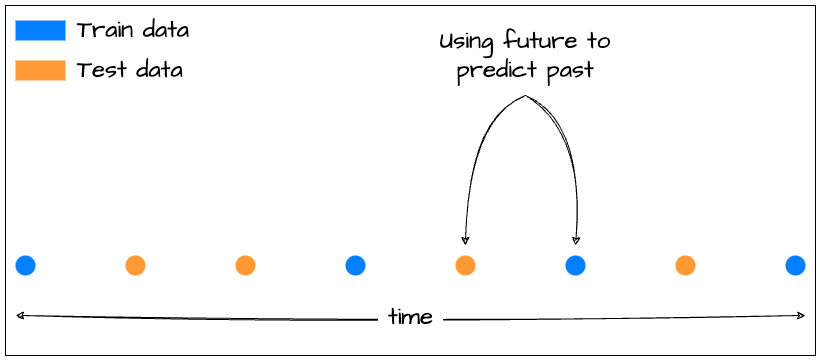


The proper way to split temporal data is to select a _split date_. Events prior to this date will be used to train the model, whereas posterior events will be used to test the model. This way, we make sure we're only using past information in our predictions.

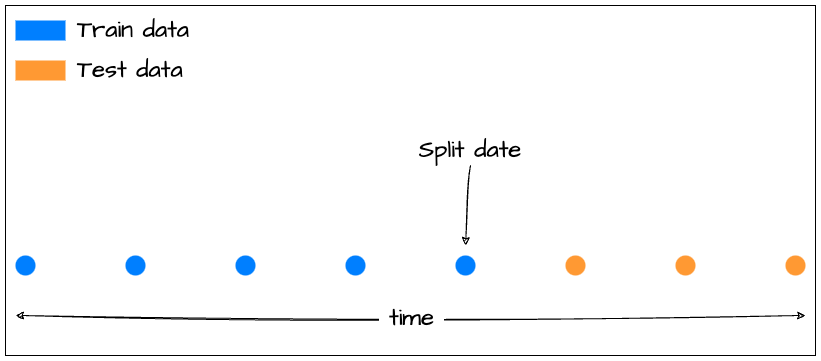

#### Question

Implement the `train_test_split` function that will split the temporal dataset `ds` into a training and a testing set. Data before (anterior) to `split_timestamp` will be the train set. Data after (posterior) to `split_timestamp` will be the test set. `timestamp_col` is the name of the column containing the timestamps.


In [ ]:
def test_train_test_split(fn):
  """A simple unit test to check your function."""
  train_ds, test_ds = fn(
      pd.DataFrame({"time":[1,2,3,4,5], "data":[6,7,8,9,10]}),
      split_timestamp=3,
      timestamp_col="time",
  )
  print("train_ds:\n",train_ds)
  print("test_ds:\n",test_ds)
  assert train_ds.equals(
      pd.DataFrame({"time":[1,2,3], "data":[6,7,8]}),
  )
  assert test_ds.equals(
      pd.DataFrame({"time":[4,5], "data":[9,10]}),
  )

if SOLVING_EXERCISES:

    def train_test_split(
        ds: pd.DataFrame,
        split_timestamp: datetime | int,
        timestamp_col: str
    ) -> tuple[pd.DataFrame, pd.DataFrame]:
        # YOUR CODE HERE
        # ...
        return ds_train, ds_test

    test_train_test_split(train_test_split)



#### Solution

In [ ]:
def train_test_split(
    ds: pd.DataFrame,
    split_timestamp: datetime | int,
    timestamp_col: str
) -> tuple[pd.DataFrame, pd.DataFrame]:
    ds_train = ds[ds[timestamp_col] <= split_timestamp].reset_index(drop=True)
    ds_test = ds[ds[timestamp_col] > split_timestamp].reset_index(drop=True)

    return ds_train, ds_test

test_train_test_split(train_test_split)

#### End of solution

In [ ]:
split_timestamp = datetime(year=1959, month=1, day=1)
ds_train, ds_test = train_test_split(ds_air, split_timestamp, "month")

print(f"Number of train samples: {len(ds_train)}")
print(f"Number of test samples: {len(ds_test)}")

Let's plot the train and test data.

In [ ]:
def plot_split(
    ds_train: pd.DataFrame,
    ds_test: pd.DataFrame,
    timestamp_col: str,
    value_col: str,
) -> int:
    split_timestamp = ds_train[timestamp_col].max()

    fig, ax = plt.subplots()

    sns.lineplot(
        data=ds_train,
        x=timestamp_col,
        y=value_col,
        label="Train data",
        ax=ax
    )
    sns.lineplot(
        data=ds_test,
        x=timestamp_col,
        y=value_col,
        label="Test data",
        ax=ax
    )
    ax.plot(
        [split_timestamp, split_timestamp],
        ax.get_ylim(),
        linestyle="-.",
        color="violet",
        alpha=0.50,
        label="Split timestamp"
    )
    ax.legend()

    return ax

plot_split(ds_train, ds_test, "month", "num_passengers")

# Evaluation metrics

When developing a model, it is important to select carefully the way the model will be evaluated.

In essence, the model will make mistakes, but not all mistakes are equal. For example, a `$10` forecasting error on a number expressed in hundreds of $ is likely worse than on a number expressed in millions of dollars.

The cost of mistake can also change in time. A `10%` error for a forecast for tomorrow might be worse than a similar `10%` error for a forecast in a year.

An evaluation function is sometimes needed by an algorithm to train a model. The evaluation function can also be used to test and compare different approaches and configurations.

There are many ways to evaluate a model's predictions. Let's list common ones:

One of the most commonly used metrics for regression problems (i.e. predicting a numerical value) is the **Mean Squared Error (MSE)**, which is computed as the averaged squared error of the model on each datapoint:

\begin{aligned}
\text{MSE} = \frac{1}{n} \sum_{t=1}^{n}\left(y_t-\hat{y}_t\right)^2
\end{aligned}

Since the MSE can be quite large for series with high values, we'll also use the **Mean Absolute Error (MAE)** and the **Mean Absolute Percent Error (MAPE)**.

The MAE should be easier to interpret because it doesn't grow quadratically with the magnitude of the error.

\begin{aligned}
\text{MAE} = \frac{1}{n} \sum_{t=1}^{n} |y_t - \hat{y}_t|
\end{aligned}

The MAPE complements our error analysis with a percentage-based assessment, making it easier to understand the relative magnitude of the forecasting errors, regardless of the scale of the data. This is particularly useful when working with Time Series of different scale, which is common in practice.

\begin{aligned}
\text{MAPE} = \frac{100%}{n} \sum_{t=1}^{n} \left\| \frac{y_t - \hat{y}_t}{y_t} \right\|
\end{aligned}

In [ ]:
def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return ((y_true - y_pred) ** 2).mean()

def mae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.abs(y_true - y_pred).mean()

def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return 100 * np.mean(
        np.abs((y_true - y_pred) / (y_true + np.finfo(float).eps)) # + epsilon for numerical stability
    )

Now that we have train and test datasets and an evaluation metric, we can calculate the performance of our first baseline.

Don't get too excited though, this is probably the simplest, moist naive forecasting modeling that one can implement.

Still, it's useful to get some baseline metrics to improve upon and to get familiar with the usual forecasting API you'll find in most Python forecasting libraries.

#### Exercise

Your task is to fill the methods of the `LastValueForecast` class below. This class defines the "last value" forecaster. This forecaster simply returns the last known value of the time series as the forecast for all steps or horizons.

This predictor is generally not competitive, but it is a great way to test our metrics and plotting functions.


In [ ]:
if SOLVING_EXERCISES:
    class LastValueForecast:
        def __init__(self):
            self.value = None

        def fit(self, y_train: np.ndarray) -> "LastValueForecast":
            # YOUR CODE HERE
            # ...
            return self

        def predict(self, num_steps: int) -> np.ndarray:
            # YOUR CODE HERE
            # ...
            return np.array(...)


#### Solution

In [ ]:
class LastValueForecast:
    def __init__(self):
        self.value = None

    def fit(self, y_train: np.ndarray) -> "LastValueForecast":
        self.value = y_train[-1]
        return self

    def predict(self, num_steps: int) -> np.ndarray:
        if self.value is None:
            raise ValueError("The estimator hasn't been fit.")

        return np.array([self.value] * num_steps)

#### End of solution

Let's augment our plotting function to also plot the predictions of our forecaster.

In [ ]:
# Define a function to plot forecast
def plot_forecast(
    ds_train: pd.DataFrame,
    ds_test: pd.DataFrame,
    forecast: np.ndarray,
    timestamp_col: str,
    value_col: str
) -> None:
    ax = plot_split(ds_train, ds_test, timestamp_col, value_col)
    sns.lineplot(
        x=ds_test[timestamp_col],
        y=forecast,
        label="Forecast",
        color="g",
        ax=ax
    )
    ax.legend()

# Instance model, fit it, and make predictions
model = LastValueForecast().fit(ds_train["num_passengers"].to_numpy())
forecast_base = model.predict(len(ds_test))

# Plot forecast
plot_forecast(ds_train, ds_test, forecast_base, "month", "num_passengers")

As expected, the forecasting is a flat line connecting to the last known value (right side of the blue curve).

Let's define `calculate_metrics` to compute all of our metrics.

Note that in practice, you will only plot the metrics (or in some cases, metrics) that you care about.


In [ ]:
def calculate_metrics(
    y_true: np.ndarray,
    y_pred: np.ndarray
) -> dict[str, float]:
    return {
        "mse": mse(y_true, y_pred),
        "mae": mae(y_true, y_pred),
        "mape": mape(y_true, y_pred)
    }

df_metrics = pd.DataFrame({"model": [], "mse": [], "mae": [], "mape": []})
df_metrics = df_metrics.set_index("model")

metrics_base = calculate_metrics(ds_test["num_passengers"], forecast_base)
df_metrics.loc["last value"] = metrics_base

df_metrics

# AR, ARMA and ARIMA models

The AR (Auto Regressive) model is a simple (simplest?) and classical forecasting method for univariate time series where the prediction is a linear combination of the past values:

$$
s[t+1] = \alpha_0 s[t] + \alpha_1 s[t-1] + \alpha_2 s[t-2] + ... + \alpha_n s[t-n]
$$

The parameters of the model ($\alpha$) can be well estimated automatically. However, finding the optimal number of parameters $n+1$ (i.e., how many past values the model has access to) is more tricky: Increasing $n$ makes the AR model more powerful and able to express more complex relations. However, having a more complex model runs the risk of overfitting: The quality of the predictions will improve on the training dataset (dataset used to estimate the $\alpha$), but this model will perform poorly on new unseen data.

#### Exercise

Fill the following code to train and evaluate an AR model using [statsmodels's AR function](https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html).


In [ ]:
if SOLVING_EXERCISES:
  from statsmodels.tsa.ar_model import AutoReg
  model = ...

#### Solution

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(
    endog=ds_train["num_passengers"],
    lags=8,
).fit()

#### End of solution

In [ ]:
# Generate forecast
forecast_arima = model.forecast(steps=len(ds_test))

# Plot results
plot_forecast(ds_train, ds_test, forecast_arima.to_numpy(), "month", "num_passengers")

In [ ]:
# Evaluate forecast and compare to past models
metrics_arima = calculate_metrics(ds_test["num_passengers"], forecast_arima.to_numpy())
df_metrics.loc["ar"] = metrics_arima
df_metrics

This new forecast is slightly better than the last value forecast, but we can see visually that further improvement should be possible. For example, the model does not seem to capture the yearly periodicity.

Interestingly, `statsmodels`' API allows us to inspect the model's parameters ($\alpha$) by inspecting the `params` attribute of the `ARIMAResults` object.

In [ ]:
model.params

#### Question

What can you infer from the model's parameters' values? What considerations should you take into account when using these to extract conclusions from the data?

#### Solution

The magnitude of the first lag's coefficient is significantly larger than the
others. This means that the model is paying a lot of attention to this value
to make the forecast. This is not ideal, since the time series appears to have
a seasonal pattern, i.e., it's correlated with T-lagged (where T is the period)
versions of itself. Ideally, we'd want the model to pay more attention to those lags.

#### End of solution

In the previous solution, we used n (a.k.a the "lags" parameters) equal to 8 (i.e., 8 months). Maybe, 8 months is not enough to capture the yearly patterns.

#### Question

Train an AR model with a 12 months and 24 months args.


In [ ]:
if SOLVING_EXERCISES:
  forecast_12m = ...
  forecast_24m = ...

#### Solution

In [ ]:
model_12m = AutoReg(endog=ds_train["num_passengers"], lags=12).fit()
model_24m = AutoReg(endog=ds_train["num_passengers"], lags=24).fit()

forecast_12m = model_12m.forecast(steps=len(ds_test))
forecast_24m = model_24m.forecast(steps=len(ds_test))

#### End of solution

Let's plot and evaluate the predictions.

In [ ]:
plot_forecast(ds_train, ds_test, forecast_12m.to_numpy(), "month", "num_passengers")
plot_forecast(ds_train, ds_test, forecast_24m.to_numpy(), "month", "num_passengers")

df_metrics.loc["ar 12m"] = calculate_metrics(ds_test["num_passengers"], forecast_12m.to_numpy())
df_metrics.loc["ar 24m"] = calculate_metrics(ds_test["num_passengers"], forecast_24m.to_numpy())

df_metrics

Using more past values yielded much better predictions.

Informally, increasing the number of past observations used by the model increases the power of the model. With higher parameters, the model is able to express more complex relations - but also runs the risk of learning the noise (a.k.a overfitting).

In practice, those parameters are selected using data analysis, expert knowledge, and automated techniques.

The relation between model power and overfitting is a central topic to machine learning. This is something to consider what ever method you use.



This AR model is still limited in power and can be extended. For example:

- The ARMA model (autoregressive–moving-average) also uses the past forecast errors to make predictions.

- The ARIMA model (AutoRegressive Integrated Moving Average) also uses the difference between past observations (called integration term).

- The SARIMA model also uses seasonality information

Those more complex models are also available in
 the statsmodels library. Note that with more complex models, the risk of overfitting increases.


#### Question

Train, plot the predictions and evaluate, an ARIMA model with parameters p=5, q=1, and d=1.

[ARIMA documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html)

In [ ]:
if SOLVING_EXERCISES:
  p,q,d = 5, 1, 1
  forecast_arima = ...  # Your code here
  plot_forecast(ds_train, ds_test, forecast_arima.to_numpy(), "month", "num_passengers")
  df_metrics.loc["arima"] = calculate_metrics(ds_test["num_passengers"], forecast_arima.to_numpy())
  df_metrics

#### Solution

In [ ]:
p,q,d = 12,2,2
model = sm.tsa.arima.ARIMA(endog=ds_train["num_passengers"],
                                    order=(p,q,d),
                                    ).fit()
forecast_arima = model.forecast(steps=len(ds_test))
plot_forecast(ds_train, ds_test, forecast_arima.to_numpy(), "month", "num_passengers")
df_metrics.loc["arima"] = calculate_metrics(ds_test["num_passengers"], forecast_arima.to_numpy())
df_metrics

#### End of solution


Note that a more complex model does not always mean a better model.

# The Autocorrelation Function

You've probably noticed that there's an oscillating pattern in the data, which repeats itself every fixed number of months.

This is known as seasonality, and it's an important concept in Time Series analysis and forecasting. A strong seasonality indicates that values every $T$ (known as the period) timestamps are highly correlated. Explicitly modelling this seasonal dependence can greatly enhance the forecasting models.

You can probably tell the period of the seasonal pattern in this example. What do you think it is?

In any case, accurately determining the period might be harder in other domains. Some domains may also exhibit non-constant seasonal beahivour which varies over time.

This is where tools such as the Autocorrelation function (ACF) come in handy. These allow us to numerically determine the seasonality without having to resort to domain-specific knowledge.

As its name states, the ACF is the correlation of the time series with a lagged version of itself.

Informally, a high correlation indicates that time series "align". So, if a timeseries aligns with itself shifted by k timesteps, this is a good indication that the time series could have a k timesteps cycle.

By examining the peaks in the ACF, we can determine if
 there is strong seasonality in the time series, as well as its period. Mathematically, this can be expressed as

\begin{aligned}
R(k) = \frac{\sum_{t=1}^{N-k} (x_t - \mu)(x_{t+k} - \mu)}{\sum_{t=1}^N (x_t - \mu)^2}
\end{aligned}


In [ ]:
def plot_acf(values: np.ndarray, max_lags: int = 20) -> None:
    acf = sm.tsa.acf(values)[:max_lags]
    lags = np.arange(len(acf))[:max_lags]

    fig, ax = plt.subplots()
    ax.stem(lags, acf)

    ax.grid(axis="y")
    ax.set_xticks(lags)
    ax.set_xlabel("lag")
    ax.set_ylabel("autocorrelation")
    ax.set_title("ACF")

plot_acf(ds_air["num_passengers"])

#### Question

What conclusions do you take from the ACF plot?

#### Solution

The magnitude of the peaks decreases as the lag increases. This is expected, as
the farther in the past the values are, the less information they contain about
future events.

However, there's a peak at the 12-lag mark, which reflects the yearly-seasonality
present in the data.

#### End of solution

# STL

STL is a time-series processing technique that decomposes the series into seasonal, trend, and residual components. It was introduced by Robert B. Cleveland, William S. Cleveland, Jean E. McRae, and Irma Terpenning in their 1990 paper titled [STL: A Seasonal-Trend Decomposition Procedure Based on Loess](https://www.wessa.net/download/stl.pdf).

STL is particularly useful for analzying time series where the seasonal component is significant and needs to be isolated from the trend and other random fluctuations in the data. This is the case in the Air Passengers dataset, as we've already identified a seasonal pattern and a growing trend in the data.

Moreover, by visually inspecting the ACF function, we discovered that the seasonal component corresponds to a 12-month period. We'll use this information as an input to the STL fitting algorithm to enhance its accuracy.

In Python, STL is implemented in the `statsmodels` package.

In [ ]:
period = 12
model = sm.tsa.STL(ds_train["num_passengers"], period=period)
result = model.fit()

result.plot();

#### Question

What insights can you derive from the STL plots?

#### Solution


Although not a perfect straight line, the trend component is effectively linear.
The amplitude of the seasonal component increases over time. This is an important
insight to take into account for future modelling techniques.
The magnitude of the residuals is small in comparison to that of time series.

#### End of solution

#### Question

Now that we've characterized the trend in the series, try picking a differencing order (`d`) to improve the performance of the ARIMA model.


TIP: try also playing with the moving average (`q`) component.

In [ ]:
if SOLVING_EXERCISES:
  model = sm.tsa.arima.ARIMA(
    endog=ds_train["num_passengers"],
    order=... # Your code here
  ).fit()

#### Solution

Since we confirmed the series has a linear trend (and not an exponential one) `d=1`, which will provide the first-order difference, should be enough to capture it.

In [ ]:
model = sm.tsa.arima.ARIMA(
    endog=ds_train["num_passengers"],
    order=(12, 2, 1),
).fit()

#### End of solution

In [ ]:
forecast_arima_2 = model.forecast(steps=len(ds_test))

plot_forecast(
    ds_train,
    ds_test,
    forecast_arima_2.to_numpy(),
    "month",
    "num_passengers"
)

metrics_arima_2 = calculate_metrics(ds_test["num_passengers"], forecast_arima_2.to_numpy())
df_metrics.loc["arima_2"] = metrics_arima_2
df_metrics

In [ ]:
model.params

#### Question

How do the model's parameters look like now? Any noticeable differences?

#### Solution

We can see that the 12-lag AR component's magnitude is the largest, and the
1st-lag AR component's magnitude has decreased. This is because the series
was de-trended before the ARIMA model was fit, which forces it to pay attention
to the seasonal pattern (which survives the de-trending process).

#### End of solution

## Discussion

For the purpose of this tutorial, we're not using a validation set. This is because we want to focus on the different forecasting techniques and not on the intricacies of proper Machine Learning problem solving.

If we tune the model to have the best possible performance on the test set, we're essentially training on the test set, which makes us run the risk of overfitting our model. This beats the purpose of having a test set in the first place, and should not be done when creating models that are going to be deployed in production.


# Error Trend Seasonal models

Error Trend Seasonal (ETS) or Exponential Smoothing models are conceptually similar to STL in the sense that they decompose the time series into trend, seasonal, and residual (called error in this case) components.

The simplest form of ETS is a model with the error component only. This model doesn't have any additive (or multiplicative, as we'll explain shortly) trend, or seasonal components.

In this formulation, the forecast is given by

\begin{aligned}
        \hat{y}_{t | t-1} &= \ell_{t-1} \\
        \ell_{t} &= \alpha y_{t-1} + (1- \alpha) \ell_{t-1}
\end{aligned}

That is, the forecast at time $t$ is the previous level value. The level $\ell$ represents the smoothed or estimated value of the time series at a given point in time, stripped of any trend or seasonal effects. The value of the level is also adjusted at each time step as a linear combination of the last observed value and the previous level value. The $\alpha$ parameter controls the amount of smoothing, i.e., how much importance is given to recent observations in comparison to older observations. That's where the name "Exponential Smoothing" comes from ;)

As you might have guessed, the simple exponential smoothing model isn't very expressive. That's were the trend and seasonal components come in. As we mentioned above, the trend and seasonal components can be incorporated either additively or multiplicatively.

In the additive case, the seasonal and trend components in the series should be constant in time, i.e., the difference between the peaks and troughs of the season doesn't change and the trend increase or decrease over time is linear.

In the multiplicative case, the seasonal and trend components in the series are proportional to the level of the series, i.e., the difference between the peaks and troughs of the season varies with the level of the time series, and the trend increase or decrease over time is exponential.

#### Question

Given the patterns we've observed in the data up until now, should we use additive or multiplicative modelling for the trend and seasonal components?

#### Solution

Given that the amplitude of the seasonal component increases over time, we should
model it multiplicatively. The trend component remains constant (linear), so
it can be modeled additively.

#### End of solution

#### Question

Train an ETS model to forecast on the test dataset. Compare the results to the previous ARIMA model's.

In [ ]:
if SOLVING_EXERCISES:
    model = sm.tsa.ETSModel(
        endog=ds_train["num_passengers"],
        #error=[...],
        #trend=[...],
        #seasonal=[...],
        #seasonal_periods=[...],
    )
    model_fit = model.fit(disp=False)

#### Solution

In [ ]:
model = sm.tsa.ETSModel(
    endog=ds_train["num_passengers"].to_numpy(),
    error="add",
    trend="add",
    seasonal="mul",
    seasonal_periods=12,
)
model_fit = model.fit()

#### End of solution

In [ ]:
forecast_ets = model_fit.forecast(steps=len(ds_test))

plot_forecast(ds_train, ds_test, forecast_ets, "month", "num_passengers")

In [ ]:
metrics_ets = calculate_metrics(ds_test["num_passengers"], forecast_ets)
df_metrics.loc["ets"] = metrics_ets
df_metrics

## Automated models

As you've seen, choosing the models' parameters (also called hyper-parameters) requires some data analysis and expertise. Instead, it is possible to automatically (or semi-automatically) find the optimal parameters with "auto" variants, such as AutoARIMA instead of ARIMA.

In our example case, you'll notice that performance doesn't increase a lot when using the automatic model. This is a good illustration that automatic hyper-parameter tuning is not a magic bullet :). This is because Air Passengers is a very simple dataset, which doesn't justify using complex models. We've also already leveraged relevant patterns in the dataset (trend, seasonality).

In [ ]:
from sktime.forecasting.ets import AutoETS


model = AutoETS(trend="mul", seasonal="mul", sp=12, maxiter=100)
model_fit = model.fit(ds_train["num_passengers"].to_numpy())

forecast_auto_ets = np.array(model_fit.predict(range(len(ds_test)))).flatten() # weird API

metrics_auto_ets = calculate_metrics(ds_test["num_passengers"], forecast_auto_ets)
df_metrics.loc["auto_ets"] = metrics_auto_ets
df_metrics

# Forecast reconciliation

In this last section of the notebook, we'll introduce the concepot of Hierarchical Time Series (HTS) and Hierarchical Forecasting with reconciliation.

An HTS dataset is structured in a hierarchical (tree-like) manner, reflecting different levels of aggregation. Examples of this hierarchy are geographical (e.g. country, state, city), product-taxonomy-based (e.g., product categories, sub-categories, individual SKUs), or organizational (e.g., company, departments, teams).

The key idea is that observations at lower levels of the hierarchy sum up to observations at the higher levels. For example, a retail company's sales data at the store level can be aggregated to give total sales for each state, and these in turn can be aggregated to give overall nation-wide sales.

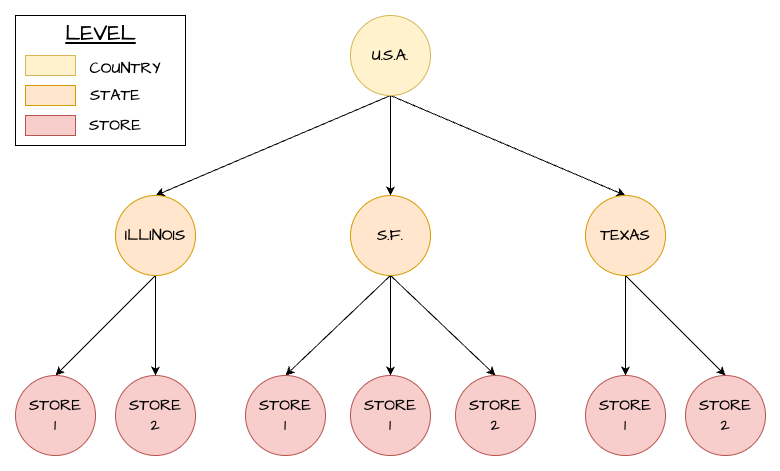


Sometimes, forecasting aggregated values (e.g., at the state level) is easier than forecasting fine grained values (e.g., at the store level). In some other cases, forecasting aggregated values might be harder.

Informally, the idea of forecasting reconciliation is to generate raw forecasts at each level (e.g. per store, aggregated by states, aggregated by country), and then to adjust those forecasts (e.g. multiply them by a value) so they match. For example, we could proportionally adjust forecasts at lower levels so they match the upper levels'.

Note that reconciliation can also be applied if you have multiple hierarchies.

In this example, we use the Australian tourism dataset. This dataset records the number of tourists in the different regions of australia.


In [ ]:
def quarter_idx(x):
    """Convert a date into a number of quarter since 1998.
    Used to solved some issue between pandas and sklearn:
    https://github.com/sktime/sktime/issues/6499
    """
    dti = pd.DatetimeIndex(x)
    return dti.quarter + (dti.year - 1998) * 4

ds_aus = (
    pd.read_csv("datasets/australian_tourism.csv", parse_dates=["Quarter"])
    .drop(columns="Index")
    .astype({"Trips": int})
)
ds_aus["Quarter"] = quarter_idx(ds_aus["Quarter"])


ds_aus.head()

## Aggregation

For the purpose of demonstrating HTS, we'll work with state-level time-series, and use the nation-wide total to reconcile their forecasts.

In [ ]:
ds_aus = (
    ds_aus[["Quarter", "State", "Trips"]]
    .groupby(["State", "Quarter"])
    .sum()
)
ds_aus

## Plotting with Temporian

We can use Temporian to quickly plot all series in the dataset individually, without having to iterate over each level and subplot.

In [ ]:
tp.plot(
    tp.from_pandas(
        ds_aus.reset_index(),
        timestamps="Quarter",
        indexes=["State"],
    ),
    features=["Trips"]
)

## Training the state-level models

In this section, we'll train a forecasting model on each of the state-level time series. We'll also train a forecaster on the nation-wide time series, which is the sum of trips for each quarter across all states.

In [ ]:
ds_train, ds_test = train_test_split(
    ds_aus.reset_index(), split_timestamp=64, timestamp_col="Quarter"
)

print(f"Train examples: {len(ds_train)}")
print(f"Test examples: {len(ds_test)}")

# Performing the aggregation

The first step we need is to aggregate the state-level time series into the nation-level time series.

This can be done with `sktime`'s [`Aggregator`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.hierarchical.aggregate.Aggregator.html) API. Doing so with this API will make it easier to use the `Reconciler` after we train the forcasting models.

In [ ]:
from sktime.transformations.hierarchical.aggregate import Aggregator


agg = Aggregator()

ds_train = agg.fit_transform(ds_train.set_index(["State", "Quarter"]))
ds_test = agg.transform(ds_test.set_index(["State", "Quarter"]))

In [ ]:
ds_train

The new `__total` level contain the nation-wide number of trips for each quarter.

In [ ]:
tp.plot(
    [
        tp.from_pandas(
            ds_train.reset_index(),
            timestamps="Quarter",
            indexes=["State"]
        ).rename({"Trips": "Train data"}),
        tp.from_pandas(
            ds_test.reset_index(),
            timestamps="Quarter",
            indexes=["State"]
        ).rename({"Trips": "Test data"})
    ],
    merge=True
)

## Training the forecasting models


In [ ]:
def train_models(
    ds_train: pd.DataFrame,
    ds_test: pd.DataFrame,
) -> pd.DataFrame:
    df_forecasts = pd.DataFrame({
        "State": [],
        "Quarter": [],
        "Forecast": [],
    })
    for state in ds_train["State"].unique():
        ds_train_state = ds_train.query("State == @state")
        ds_test_state = ds_test.query("State == @state")

        # Train
        model = sm.tsa.ETSModel(
            endog=ds_train_state["Trips"].to_numpy(),
            error="add",
            trend="mul",
            seasonal="mul",
            seasonal_periods=4,
        )
        model_fit = model.fit(disp=False)
        forecast_test = model_fit.forecast(steps=len(ds_test_state))

        df_forecasts = pd.concat(
            [
                df_forecasts,
                pd.DataFrame(
                    {
                        "State": [state] * len(ds_test_state),
                        "Quarter": ds_test_state["Quarter"].to_list(),
                        "Forecast": forecast_test
                    }
                )
            ]
        )

    return df_forecasts


df_forecasts = train_models(ds_train.reset_index(), ds_test.reset_index())

df_forecasts

In [ ]:
tp.plot(
    [
        tp.from_pandas(
            pd.concat([ds_train, ds_test]).reset_index(),
            timestamps="Quarter",
            indexes=["State"]
        ).rename({"Trips": "Raw data"}),
        tp.from_pandas(
            df_forecasts,
            timestamps="Quarter",
            indexes=["State"]
        )
    ],
    merge=True
)

In [ ]:
df_metrics = pd.DataFrame(
    {"state": [], "mse": [], "mae": [], "mape": []}
).set_index("state")
for state, df in ds_test.merge(df_forecasts, on=["State", "Quarter"]).groupby("State"):
    df_metrics.loc[state] = calculate_metrics(df["Trips"].to_numpy(), df["Forecast"].to_numpy())

df_metrics

In [ ]:
fig, ax = plt.subplots()

sns.barplot(
    df_metrics.reset_index(),
    x="mape",
    y="state",
    orient="horizontal",
    order=df_metrics.sort_values("mape").index,
    ax=ax
)

#### Question

Looking at the forecast plots and the metrics chart, there's two clear states which have much worse performance than the others. Why do you think that is?

#### Solution

If you take a look at the raw plots for those states, you'll notice there's an increasing
trend that starts towards the end of the train-test split. This implies that
the ETS model is unable to capture the trend when fitting the train data, which
is also reflected visually on the forecasts it produces.

Looking at the raw plots to obtain this conclusion could be dangerous - instead, plotting the STL for them and checking the actual trend would be a good idea.

#### End of solution

## Reconciliation

Now we'll train a reconciler on the training dataset. The reconciler will learn how to aggregate the state-level time series into the nation-level time series. This aggregation can then be used on the test dataset to improve the accuracy of both the state-level and nation-level time series.

Using `sktime`'s API, the `Reconciler` will automatically recognize the `__total` level as the nation-wide time series and aggregate the other (state) levels accordingly.

In [ ]:
from sktime.transformations.hierarchical.reconcile import Reconciler


reconciler = Reconciler(method="ols")
reconciler.fit(
    ds_train
    .reset_index()
    .astype({"Quarter": int})
    .set_index(["State", "Quarter"])
)

In [ ]:
df_forecasts = (
    df_forecasts
    .astype({"Quarter": int})
    .set_index(["State", "Quarter"])
)
df_forecasts_r = reconciler.transform(df_forecasts)

df_forecasts = (
    df_forecasts
    .merge(
        df_forecasts_r,
        left_index=True,
        right_index=True,
        suffixes=("", "_reconciled")
    )
)
df_forecasts

In [ ]:
ds_test

In [ ]:
ds_test.merge(df_forecasts, left_index=True, right_index=True).reset_index()

In [ ]:
df_metrics_r = pd.DataFrame(
    {"state": [], "mse": [], "mae": [], "mape": []}
).set_index("state")
for state, df in ds_test.merge(df_forecasts, left_index=True, right_index=True).groupby("State"):
    df_metrics_r.loc[state] = calculate_metrics(
        df["Trips"].to_numpy(), df["Forecast_reconciled"].to_numpy()
    )

df_metrics_r

In [ ]:
df_metrics_all = (
    df_metrics
    .merge(df_metrics_r, left_index=True, right_index=True, suffixes=("", "_r"))
)

df_metrics_all

In [ ]:
df_mape_melt = (
    df_metrics_all[["mape", "mape_r"]]
    .reset_index()
    .melt(id_vars="state", value_vars=["mape", "mape_r"])
    .replace({"mape": "base", "mape_r": "reconciled"})
    .rename(columns={"variable": "method", "value": "mape"})
)
df_mape_melt

In [ ]:
fig, ax = plt.subplots()

sns.barplot(
    df_mape_melt,
    x="mape",
    y="state",
    hue="method",
    orient="horizontal",
    order=df_metrics.sort_values("mape").index,
    ax=ax
)

In this example, the reconciled forecasts are better for all states AND the nation-level time series.